In [1]:
from sqlalchemy import create_engine, Column, String, Integer, DATE, BOOLEAN
from sqlalchemy.orm import sessionmaker

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import func

import json

## Setup our `sqlalchemy`

Load the server credentials so we can actually look at our data. We'll use a `pandas` DataFrame object to hold the infomation locally and do some exploration.

In [2]:
with open('../../postgres.json') as pg_info:
    pg_json = json.load(pg_info)
    pg_username = pg_json['pg_username']
    pg_password = pg_json['pg_password']
    pg_ip = pg_json['pg_ip']

In [3]:
Base = declarative_base()

class articles_detex(Base):
    __tablename__ = 'arxiv_detex'
    
    id = Column(String, primary_key=True)
    created = Column(DATE)
    setspec = Column(String)
    
    title = Column(String)
    title_converted = Column(BOOLEAN)
    
    abstract = Column(String)
    abstract_converted = Column(BOOLEAN)

class articles_pandoc(Base):
    __tablename__ = 'arxiv_pandoc'
    
    id = Column(String, primary_key=True)
    created = Column(DATE)
    setspec = Column(String)
    
    title = Column(String)
    title_converted = Column(BOOLEAN)
    
    abstract = Column(String)
    abstract_converted = Column(BOOLEAN)
    


In [4]:
engine = create_engine(f'postgres://{pg_username}:{pg_password}@{pg_ip}:5432')
Session = sessionmaker(bind=engine)


## Conversion Failures

We went through all the trouble of trying to remove the $\LaTeX$, and at least recorded when our methods failed. Let's go check what happened with that, i.e. how often did `detex` and `pandoc` fail?

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
def conversion_rates(article_class, Session, column='title'):
    
    if column == 'title':
        article_column = article_class.title_converted
    elif column == 'abstract':
        article_column = article_class.abstract_converted
    else:
        print('column must be either "title" or "abstract"')
        return

    session = Session()
    
    query = session.query(article_column, func.count(article_column))
    query = query.group_by(article_column)
    
    df = pd.read_sql(query.statement, query.session.bind).set_index(column + '_converted')
    session.close()
    
    return df

In [10]:
df_detex_title = conversion_rates(articles_detex, Session, column='title')
df_detex_title

,count_1
title_converted,
True,1407628


In [11]:
df_detex_abstract = conversion_rates(articles_detex, Session, column='abstract')
df_detex_abstract

,count_1
abstract_converted,
True,1407628


The tables above show us that `pandoc` didn't issue an error and returned a value when we tried to process the titles and abstracts. Of course this doesn't mean all is well, let's check the `pandoc` results.

In [12]:
df_pandoc_title = conversion_rates(articles_pandoc, Session, column='title')
df_pandoc_title

,count_1
title_converted,
False,14153
True,1393475


In [23]:
num_articles = df_pandoc_title.count_1.sum()

In [27]:
print(f'pandoc fail rate for TITLES: {100*df_pandoc_title.count_1[False]/num_articles:.2f}%')
print(f'pandoc success rate for ABSTRACTS: {100*df_pandoc_title.count_1[True]/num_articles:.2f}%')

pandoc fail rate for TITLES: 1.01%
pandoc success rate for ABSTRACTS: 98.99%


In [30]:
df_pandoc_abstract = conversion_rates(articles_pandoc, Session, column='abstract')
df_pandoc_abstract

,count_1
abstract_converted,
False,93656
True,1313972


In [31]:
print(f'pandoc fail rate for TITLES: {100*df_pandoc_abstract.count_1[False]/num_articles:.2f}%')
print(f'pandoc success rate for ABSTRACTS: {100*df_pandoc_abstract.count_1[True]/num_articles:.2f}%')

pandoc fail rate for TITLES: 6.65%
pandoc success rate for ABSTRACTS: 93.35%


So we definitely didn't do as well as with `detex`, but overall I'd say this looks pretty good.

## Make some plots here

This is a bit tnagential to the task, but it's always an excellent idea to be intimately familiar with your data. Let's have a look at the history of submissions to `arXiv`. For example we can plot the number of submissions on any given day. 

In [107]:
session = Session()

query = session.query(articles_pandoc.created, func.count(articles_pandoc.created))
query = query.group_by(articles_pandoc.created) 
submissions_by_date = pd.read_sql(query.statement, query.session.bind)

session.close()

In [108]:
submissions_by_date.set_index('created', inplace=True)

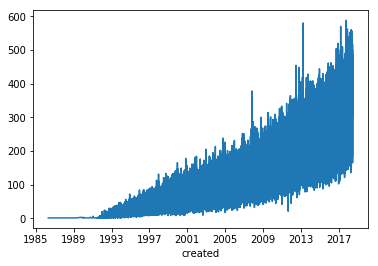

In [121]:
plot_params = {
    'kind':'line',
    'legend':False
}

submissions_by_date.plot(**plot_params)

## INTEERESTING!

In [117]:
first, *tmp, last = submissions_by_date.index[:5]

In [118]:
session = Session()

query = session.query(articles_pandoc)
query = query.filter(articles_pandoc.created <= last)
early_submissions = pd.read_sql(query.statement, query.session.bind)

session.close()

In [119]:
early_submissions.sort_values(by='created')

,id,created,setspec,title,title_converted,abstract,abstract_converted
3,physics/9403001,1986-04-25,physics:hep-th,Desperately Seeking Superstrings\n,True,We provide a detailed analysis of the problems...,True
2,hep-th/9108028,1988-11-11,physics:hep-th,Applied Conformal Field Theory\n,True,These lectures consisted of an elementary intr...,True
6,math/9201239,1989-04-14,math,A note on canonical functions\n,True,We construct a generic extension in which th...,False
0,math/9201203,1989-10-26,math,Convex bodies with few faces\n,True,"It is proved that if u₁, …, u_(n) are vectors ...",True
1,math/9201205,1989-10-26,math,Volume ratios and a reverse isoperimetric ineq...,True,It is shown that if C is an n-dimensional conv...,True
4,math/9201204,1989-10-26,math,Shadows of convex bodies\n,True,It is proved that if C is a convex body in ${\...,True
5,math/9201206,1989-11-09,math,On the volume of the intersection of two L_(p)...,True,"This note deals with the following problem, th...",True


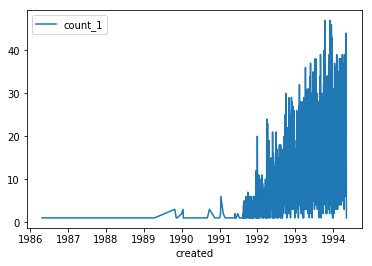

In [124]:
submissions_by_date[:1000].plot(kind='line')

## Submissions by Category

In [5]:
session = Session()
setspecs = set()
for value in session.query(articles_pandoc.setspec).distinct():
     setspecs.add(value)
session.close()

In [6]:
setspecs

{('cs'),
 ('econ'),
 ('eess'),
 ('math'),
 ('nlin'),
 ('physics:astro-ph'),
 ('physics:cond-mat'),
 ('physics:gr-qc'),
 ('physics:hep-ex'),
 ('physics:hep-lat'),
 ('physics:hep-ph'),
 ('physics:hep-th'),
 ('physics:nlin'),
 ('physics:nucl-ex'),
 ('physics:nucl-th'),
 ('physics:physics'),
 ('physics:quant-ph'),
 ('q-bio'),
 ('q-fin'),
 ('stat')}

In [7]:
session = Session()

query = session.query(articles_pandoc.created, func.count(articles_pandoc.created))
query = query.filter(articles_pandoc.setspec == 'math')
query = query.group_by(articles_pandoc.created)
math_submissions = pd.read_sql(query.statement, query.session.bind)

session.close()

In [9]:
math_submissions.set_index('created', inplace=True)

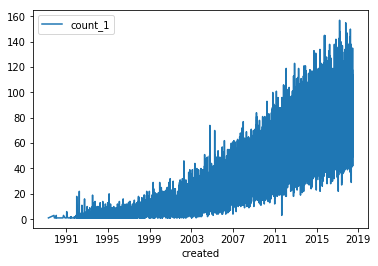

In [24]:
math_submissions.plot(kind='line')